In [2]:
import os
import sys
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## Read in files and make dfs (long for plotting, and summaries for printing to csv)

In [3]:
def read_coeff_file_wide(result_file):

    to_read = glob(result_file)[0]
    coeffs = pd.read_csv(to_read, index_col=0)
    coeffs.index.name = 'Coefficient'
    coeffs.drop(['cv'], inplace=True)
    
    return coeffs

In [15]:
### turns a wide df into long, with columns: ['Coefficients' ,'value', 'home', 'C']
def make_long_coeff_df(df, cols_to_drop=[], remove_lags=False):
    
    
    df['Coefficients'] = df.index
    if remove_lags:
        lag1 = df.loc['lag1_occupied']
        df = df[~df['Coefficients'].str.contains('lag')]
        df = df.append(lag1)
        df = df.replace(['lag1_occupied', 'hr_sin', 'hr_cos'], ['1hr lag', 'sin(hr)', 'cos(hr)'])
    coeffs = df.drop(cols_to_drop)
    long_coeffs = coeffs.melt(id_vars=['Coefficients'])
    
#     long_coeffs[['home', 'C']] = long_coeffs.variable.str.split(', ', expand=True)
#     long_coeffs['home'] = long_coeffs['home'].map(lambda x: str(x)[:2])
#     long_coeffs['home'] = long_coeffs['home'].map(lambda x: str(x)[5:7])

    long_coeffs = long_coeffs.drop(columns=['variable'])
    
    return long_coeffs


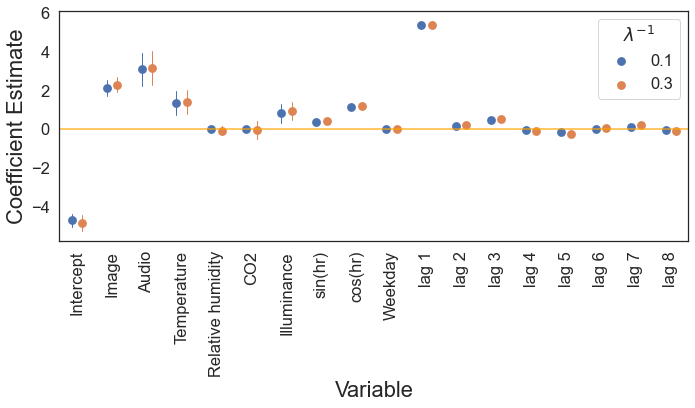

In [224]:
def read_in_c_coeffs(all_coeffs_file, joined=True, C=0.1):
    df = read_coeff_file_wide(all_coeffs_file)
    
    if joined:  
        keep_cols = [col for col in df.columns if 'all' in col]
        df = df[keep_cols]   
    else:
        keep_cols = [col for col in df.columns if 'all' not in col]
        df = df[keep_cols]
    df['Coefficients'] = df.index
    df.drop(['C','home'], inplace=True)
    
    df = df.melt(id_vars=['Coefficients'])
    df['C'] = C
    
#     df.to_csv('/Users/maggie/Desktop/test_coffs_after.csv')
    df[['test', 'home', 'group']] = df.variable.str.split(' ', expand=True)
    df.drop(columns=['variable', 'test', 'group'], inplace=True)

#     print(df)

#     df.to_csv('/Users/maggie/Desktop/test_coffs_after.csv')

    df.value = pd.to_numeric(df.value)

    return df

coeffs_fc1 = '/Users/maggie/Desktop/ARLR_results/Dissertation_round_of_results/all_results/baseline_C01/coeffs_baseline.csv'
coeffs_fc3 = '/Users/maggie/Desktop/ARLR_results/Dissertation_round_of_results/all_results/baseline_C03/coeffs_baseline.csv'
coeffs_fc05 = '/Users/maggie/Desktop/ARLR_results/Dissertation_round_of_results/all_results/baseline_C005/coeffs_baseline.csv'

c1 = read_in_c_coeffs(all_coeffs_file=coeffs_fc1, C=0.1, joined=True)
c3 = read_in_c_coeffs(all_coeffs_file=coeffs_fc3, C=0.3, joined=True)
# c05 = read_in_c_coeffs(all_coeffs_file=coeffs_fc05, C=0.05)

c1_gp = read_in_c_coeffs(all_coeffs_file=coeffs_fc1, C=0.1, joined=False)
c1_gp = c1_gp.groupby(['home', 'Coefficients', 'C']).mean().reset_index()

c3_gp = read_in_c_coeffs(all_coeffs_file=coeffs_fc3, C=0.3, joined=False)
c3_gp = c3_gp.groupby(['home', 'Coefficients', 'C']).mean().reset_index()
c3_gp

coeffs_homes = pd.concat([c1_gp, c3_gp],axis=0)
coeffs_homes.index = coeffs_homes['Coefficients']


long_coeff_joined = pd.concat([c1, c3],axis=0)
long_coeff_joined.index = long_coeff_joined['Coefficients']
# long_coeff_joined.drop(['home', 'C'], inplace=True)
# long_coeff_joined

# plot_coeffs_long(coeffs_homes,title='2Cs_single_homes')
plot_coeffs_long(long_coeff_joined,title='joined')

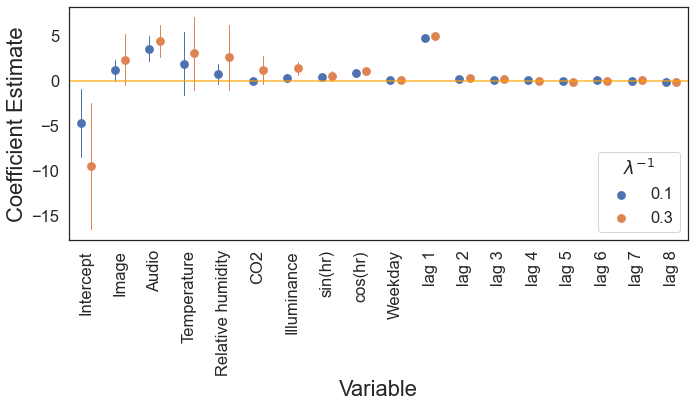

In [221]:
x_cols = {
        'Intercept': 'Intercept',
        'img': 'Image',
        'audio': 'Audio',
        'temp': 'Temperature',
        'rh': 'Relative humidity',
        'co2eq': 'CO2',
        'light': 'Illuminance',
        'hr_sin': 'sin(hr)',
        'hr_cos': 'cos(hr)',
        'weekend': 'Weekday'
        }

def plot_coeffs_long(df, title='', lag_plot=8, max_lags=8):
    sns.set(style='white')
    sns.set_context('notebook', font_scale=1.5)   
    df.value = pd.to_numeric(df.value)
#     df.loc[df['home'] != 'H4']
#     print(df)
    
    for lag_str in [f'lag{i}_occupied' for i in range(lag_plot+1, max_lags+1)]:
#         print(lag_str)
        df = df[~df.Coefficients.str.contains(lag_str)]
#     print(df)

    lags = [f'lag{i}_occupied' for i in range(1,lag_plot+1)]
    cols = [k for k in x_cols] + lags
#     print(lags)
    lag_strs = [f'lag {i}' for i in range(1,lag_plot+1)]
    x_axis_dict = [k for k in x_cols.values()] + lag_strs

    fig, ax = plt.subplots(figsize=(10,6))

    g = sns.pointplot(x='Coefficients', y='value', hue='C', data=df, join=False, dodge=.3, errwidth=1, ci='sd', ax=ax, order=cols, legend=False)
    ax.axhline(y=0, linestyle='-', color='orange', linewidth=1.5, alpha=.8)
    ax.set_ylabel('Coefficient Estimate',fontsize=22)
    ax.set_xlabel('Variable',fontsize=22)
    ax.get_legend().set_title('$\lambda^{-1}$')


    g.set_xticklabels(x_axis_dict)
    plt.xticks(rotation=90)
    plt.tight_layout()
#     print(df)
    
    df = df.reset_index(drop=True)
    df_mean = df.groupby(['Coefficients', 'C']).mean().reset_index()
    df_mean = df_mean.rename(columns={'value': 'Mean'})
    df_std = df.groupby(['Coefficients', 'C']).std().reset_index()
    df_std = df_std.rename(columns={'value': 'Std Dev'})
    df_gpby = pd.concat([df_mean, df_std], axis=1)
    df_gpby = df_gpby.T.drop_duplicates().T
#     print(df_gpby)
#     print(df_gpby[['Coefficients','C']])
    for c in df_gpby.C.unique():
        coeff_df = df_gpby.loc[df_gpby['C'] == c]
#         print(coeff_df)
        coeff_df.to_csv(f'/Users/maggie/Desktop/new_dissertation_images/coeffs_{title}_{c}.csv')

#     print(df)
    plt.savefig(f'/Users/maggie/Desktop/new_dissertation_images/coeffs_{title}.pdf')



# plot_coeffs_long(coeffs_homes,title='2Cs_single_homes')

In [ ]:
### Turn long df into summaries with mean and standard deviation, using groupby

def groupby_long(long_df, col_to_numeric, columns):
    long_df[col_to_numeric] = pd.to_numeric(long_df[col_to_numeric])
    grpby_mean = long_df.groupby(columns).mean()
    grpby_std = long_df.groupby(columns).std()
    grpby_mean.columns = [['mean']]
    grpby_std.columns = [['stdev']]

    summary_df = pd.concat([grpby_mean, grpby_std], axis=1)
    summary_df.reset_index(inplace=True)
    
    return summary_df


***
## Graphing

In [ ]:
### plot coeffieicnets for models trained on subgroups

all_coeffs_file = '/Users/maggie/Desktop/to_read/all_CV_coeffs.csv'
coeffs_raw = read_coeff_file_wide(all_coeffs_file) 
to_drop = ['accuracy', 'C', 'home', 'cross acc', 'cross f1', 'cross f1 neg', 'cross mcc', 'gt acc', 'gt mcc', 'gt f1', 'self acc', 'self f1', 'self f1 neg', 'self mcc']
long_coeff = make_long_coeff_df(coeffs_raw, cols_to_drop=to_drop)

# Cs = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9]
# for C in Cs:
#     plot_coeffs_long(long_coeff, C=C, title='all')
plot_coeffs_long(long_coeff, C=0.3, title='all')
    

In [ ]:
### plot coeffieicnets for models trained on all homes (-1)
# all_coeffs_file = '/Users/maggie/Desktop/to_read/joined_homes_CV_coeffs.csv'
# all_coeffs_file = '/Users/maggie/Desktop/Results_c03_incCO2/all_CV_coeffs_incCO2.csv'

to_drop = ['accuracy', 'C', 'home']

coeff_file_joined_L8 = '/Users/maggie/Desktop/joined_homes_CV_coeffs_lag8_3c.csv'
coeffs_raw_L8 = read_coeff_file_wide(coeff_file_joined_L8)
long_coeff_L8 = make_long_coeff_df(coeffs_raw_L8, cols_to_drop=to_drop)
long_coeff_L8['Lags'] = 8

coeff_file_joined_L2 = '/Users/maggie/Desktop/joined_homes_CV_coeffs_lag2_3c.csv'
coeffs_raw_L2 = read_coeff_file_wide(coeff_file_joined_L2)
long_coeff_L2 = make_long_coeff_df(coeffs_raw_L2, cols_to_drop=to_drop)
long_coeff_L2['Lags'] = 2

coeff_file_joined_L16 = '/Users/maggie/Desktop/joined_homes_CV_coeffs_lag16_3c.csv'
coeffs_raw_L16 = read_coeff_file_wide(coeff_file_joined_L16)
long_coeff_L16 = make_long_coeff_df(coeffs_raw_L16, cols_to_drop=to_drop)
long_coeff_L16['Lags'] = 16

all_lags = pd.concat([long_coeff_L2, long_coeff_L8, long_coeff_L16])
all_lags

# long_coeff_L2
# Cs = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9]
# for C in Cs:
#     plot_coeffs_long(long_coeff, C=C, title='joined')

plot_coeffs_long(all_lags, C=0.3, title='3_lags')

***
# Read and Plot Accuraciacies

In [ ]:
def make_acc_df(df, joined=False, remove_lags=False, cols_to_drop=[]):
#     print(df)
    
    df = df.drop(cols_to_drop)

    df['Prediction Type'] = df.index

    acc_cols = ['Prediction Type', 'Accuracy', 'F1', 'F1 neg', 'self/cross', 'test']


    acc_long = acc.melt(id_vars=['Prediction Type'])
    
    acc_long[['home', 'C']] = afcc_long.variable.str.split(', ', expand=True)
    acc_long['home'] = acc_long['home'].map(lambda x: str(x)[:2])
    acc_long = acc_long.drop(columns=['variable'])
    acc_long = acc_long.rename(columns={'Coefficients': 'Type', 'value':'Accuracy'})
    acc_long = acc_long.dropna()
    acc_long.Type = acc_long.Type.str.replace('f1 neg', 'f1_neg', regex=True)
    acc_long[['group type', 'acc type']] = acc_long['Type'].str.split(pat=' ', expand=True)
    acc_long.to_csv('/Users/maggie/Desktop/Accuracies_test.csv')
    acc_long['Accuracy'] = pd.to_numeric(acc_long['Accuracy'])
    acc_long = acc_long.loc[acc_long['group type'] != 'gt']
    
    return acc_long


In [ ]:
### turns a wide df into long df for accuacies (self and cross group)

def make_long_acc_df(df, joined=False, remove_lags=False, cols_to_drop=[]):
    print(df)
    
    df = df.drop(cols_to_drop)
    
    if joined:
        acc_cols = ['cross acc', 'cross f1', 'cross f1 neg', 'cross mcc']
    else:
        acc_cols = ['cross acc', 'cross f1', 'cross f1 neg', 'cross mcc', 'gt acc', 'gt mcc', 'self acc', 'self f1', 'self f1 neg', 'self mcc']

    df['Coefficients'] = df.index
    acc = df.loc[acc_cols]
    acc_long = acc.melt(id_vars=['Coefficients'])
    
    acc_long[['home', 'C']] = afcc_long.variable.str.split(', ', expand=True)
    acc_long['home'] = acc_long['home'].map(lambda x: str(x)[:2])
    acc_long = acc_long.drop(columns=['variable'])
    acc_long = acc_long.rename(columns={'Coefficients': 'Type', 'value':'Accuracy'})
    acc_long = acc_long.dropna()
    acc_long.Type = acc_long.Type.str.replace('f1 neg', 'f1_neg', regex=True)
    acc_long[['group type', 'acc type']] = acc_long['Type'].str.split(pat=' ', expand=True)
    acc_long.to_csv('/Users/maggie/Desktop/Accuracies_test.csv')
    acc_long['Accuracy'] = pd.to_numeric(acc_long['Accuracy'])
    acc_long = acc_long.loc[acc_long['group type'] != 'gt']
    
    return acc_long


In [ ]:
### compare accuries for different model types

def compare_classifiers(result_file, to_compare):
    to_read = glob(result_file)[0]
    metrics = pd.read_csv(to_read, index_col=0)
    metrics = metrics.loc[(metrics.index == to_compare[0])| (metrics.index == to_compare[1])]
    cols_to_keep = ['Accuracy', 'F1', 'F1 neg', 'MCC', 'train', 'test']
    metrics = metrics[cols_to_keep]
    metrics['Classifier'] = metrics.index
    metrics_long = metrics.melt(id_vars=['Classifier', 'train', 'test'], var_name='Metric', value_name='Value')

    return metrics_long

In [ ]:
### get train/test compared predictions

def summarize_metric(to_read, metric_sum='Accuracy'):
    metrics = pd.read_csv(to_read, index_col=0)
    acc = 'AR predictions'
    metrics = metrics.loc[(metrics.index == acc)]
    cols_to_keep = [metric_sum, 'train', 'test']
    metrics = metrics[cols_to_keep]
    metrics_long = metrics.melt(id_vars=['train', 'test'], var_name='Metric', value_name='Value')
    
    gp_compare = groupby_long(metrics_long, col_to_numeric='Value', columns=['train', 'test'])
    gp_compare.columns = ['train', 'test', 'mean', 'stdev']
    gp_compare = gp_compare.pivot(index=['train'], columns=['test'], values=['mean'])
    gp_compare.columns = gp_compare.columns.droplevel()
    return gp_compare

    
to_read = '/Users/maggie/Desktop/to_read/all_metrics_0.3.csv'
compared = summarize_metric(to_read)
compared.to_csv('/Users/maggie/Desktop/accuracy_train_test_compare.csv')


In [ ]:


to_compare = ['OR (ai)', 'AR predictions']
all_metrics_file = '/Users/maggie/Desktop/to_read/all_metrics_0.3.csv'
# all_metrics_file = '/Users/maggie/Desktop/to_read/joined_homes_CV_metrics.csv'

metrics = compare_classifiers(all_metrics_file, to_compare) 
# metrics = metrics.loc[(metrics.train != 'H4') & (metrics.test != 'H4')]
metrics['self/cross'] = 'cross'
metrics.loc[metrics.train == metrics.test, 'self/cross'] = 'self'
metrics = metrics.loc[(metrics.Metric != 'F1 neg') & (metrics.Metric != 'MCC')]
# metrics.to_csv('/Users/maggie/Desktop/metrics_co_group.csv')

gpby = groupby_long(long_df=metrics, col_to_numeric='Value', columns=['Metric', 'Classifier', 'self/cross'])

gpby.to_csv('/Users/maggie/Desktop/OR_AR_compared.csv')
gpby


# groupby_long()
# to_drop = ['accuracy', 'C', 'home', 'gt f1']
# long_acc = make_long_acc_df(coeffs_raw, cols_to_drop=to_drop)

# plot_acc_compared(long_acc, combine=False, title='self_cross')

In [ ]:
new_acc = long_acc.loc[long_acc['home'] != 'H4']
print(new_acc)
new_acc = new_acc.loc[new_acc['acc type'].isin(['acc', 'f1', 'f1_neg'])]
new_df = new_acc.groupby(['group type', 'acc type', 'C']).mean().reset_index()

In [ ]:
# print(new_acc.columns)
new_acc = new_acc.rename(columns={'group type': 'Test', 'Accuracy':'Value', 'acc type':'Metric'})
# print(new_acc)
plot_acc = new_acc.loc[(new_acc['$\lambda^{-1}$'] != '0.09') & (new_acc['$\lambda^{-1}$'] != '0.9')]
# print(plot_acc)
sns.set(style='whitegrid')
sns.set_context('notebook', font_scale=1.5)


# g = sns.relplot(data=new_acc, x='C', y='Accuracy', hue='group type', height=6, aspect=1, kind='line', col='acc type')
g = sns.relplot(data=plot_acc, x='$\lambda^{-1}$', y='Value', hue='Test', height=4, aspect=1.3, kind='line', col='Metric')

# plt.tight_layout()

titles = ['Accuracy', '$F_1$', '$F_{1^-}$']
for i, ax in enumerate(g.axes.flat):
    ax.set_title(titles[i])
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.savefig(f'/Users/maggie/Desktop/new_dissertation_images/C_compared.pdf')

# sns.relplot(data=new_acc.loc[new_acc['acc type']=='f1'], x='C', y='Accuracy', hue='group type', height=6, aspect=1.7, kind='line')

In [ ]:
### Read in joined coeffs (trained on all but one home, tested on remaining home)
# coeff_file_joinedL8 = '/Users/maggie/Desktop/joined_homes_CV_coeffs_lag8_3c.csv'
coeff_file_joined = '/Users/maggie/Desktop/to_read/joined_homes_CV_coeffs.csv'
# coeffs_joined = read_coeff_file_wide(coeff_file_joinedL8)

to_drop = ['accuracy', 'C', 'home']
joined_coeffs_long = make_long_acc_df(coeffs_joined, cols_to_drop=to_drop, joined=True)

# plot_acc_compared(joined_coeffs_long, combine=True, title='CV')

In [ ]:
### Plotting function

def plot_acc_compared(long_df, combine=False, title=''):
    sns.set(style='whitegrid')
    sns.set_context('notebook', font_scale=2)
    y_axis_dict = {'acc':'Accuracy', 'f1':'F1 Score', 'f1_neg': 'F1 Score (Rev)', 'mcc': 'Matthews Corr. Coef.'}

    for t in long_df['acc type'].unique():
        df = long_df.loc[long_df['acc type'] == t]    

        if not combine:
            ## showing self vs cross
            g = sns.catplot(x='C', y='Accuracy', row='acc type', col='group type', data=df, kind='bar', height=6, aspect=1.7, errwidth=1.5,)#, capsize=.1, alpha=0.9, errwidth=1.5, legend_out=True)
            g.set_ylabels(y_axis_dict[t])
            axes = g.axes.flatten()
            axes[0].set_title('Cross Test')
            axes[1].set_title('Self Test')

        else:
            ## combining self and cross
            g = sns.catplot(x='C', y='Accuracy', row='acc type',  data=df, kind='bar', height=6, aspect=1.7, errwidth=1.5,)#, capsize=.1, alpha=0.9, errwidth=1.5, legend_out=True)
            g.set_ylabels(y_axis_dict[t])
            axes = g.axes.flatten()
            axes[0].set_title('')
            
        g.savefig(f'/Users/maggie/Desktop/AccuracyPlots/{t}_{title}.pdf')
    

In [ ]:
### plot accuracies from all coeffs (trained on house subgroups)

all_coeffs_file = '/Users/maggie/Desktop/to_read/all_CV_coeffs.csv'
coeffs_raw = read_coeff_file_wide(all_coeffs_file) 

to_drop = ['accuracy', 'C', 'home', 'gt f1']
long_acc = make_long_acc_df(coeffs_raw, cols_to_drop=to_drop)

# plot_acc_compared(long_acc, combine=False, title='self_cross')

***
## Previous coeffieict plotting method

In [ ]:
def plot_coeffs(coef_df, fname=''):

    sns.set_context('notebook')


    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='mean', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=8,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['mean'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    save_loc = os.path.join(parent_dir, 'Results', 'Plots', f'{fname}_coeffs.pdf')
#     plt.savefig(save_loc)
    
    return plt

In [ ]:
result_file = 'full_noCV_zeroFill'
coef_df = get_coeffs(result_file)

coef_plot = plot_coeffs(coef_df=coef_df, fname='no_CV')
coef_plot.show()

In [ ]:


def plot_coeffs(coef_df, fname='', plot_2=False):

    coeff_vars = coef_df['variables']
#     coef_df.drop(['Intercept', 'audio', 'lag1_occupied', 'lag2_occupied'], inplace=True)
    large_cols = ['Intercept', 'audio', 'lag1_occupied', 'lag2_occupied']

    for c in large_cols:
        coef_df.loc[c,:] = np.nan
    coef_df['variables'] = coeff_vars
        
    print(coef_df)
#         coef_df[c].loc[coef_df[c].isnull().any(axis=1), :] = np.nan
    sns.set_context('notebook')


    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='mean', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=8,
                 yerr='errors', legend=False)
    
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['mean'], color='steelblue', label='No CV')
    
    if plot_2:
    
        coef_df.plot(x='variables', y='mean_cv', kind='bar', width=0.6, align='edge',
                     ax=ax, color='none', fontsize=22,
                     ecolor='chocolate',capsize=8,
                     yerr='errors_cv', legend=False)

        ax.scatter(x=np.arange(coef_df.shape[0])+0.3, 
               marker='o', s=80,
               y=coef_df['mean_cv'], color='chocolate', label='Cross-validated')


        ax.legend(['Cross-validated C', 'No CV (C=0.1)'], fontsize='x-large')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    plt.ylim([-2.5, 6.5])
    
    save_loc = os.path.join(parent_dir, 'Results', 'Plots', f'{fname}_coeffs.pdf')
    
    plt.tight_layout()
    plt.savefig(save_loc)
    return plt

# C_df = C_df[['mean', 'errors', 'variables']]#.join(coef_df_cv[['mean', 'errors']], rsuffix='_cv')
# # df = coef_df[['mean', 'errors', 'variables']].join(coef_df_cv[['mean', 'errors']], rsuffix='_cv')

# # multi_coef_plot = plot_coeffs(coef_df=df, fname='multi_remove_large', plot_2=True)
# # multi_coef_plot.show()

# result_file_cv = 'full_CV_zeroFill'
# coef_df_cv = get_coeffs(result_file_cv)
# coef_cv = plot_coeffs(coef_df=coef_df_cv, fname='CV')
# coef_cv.show()